In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q "/content/drive/My Drive/cassava1.zip"

In [0]:
data_dir = '/content/cassava'
train_dataset = datasets.ImageFolder(root=traindir,transform=transform_train)
test_dataset = datasets.ImageFolder(root=data_dir,transform=transform_test)
num_classes = len(train_dataset.classes)
 
class_sample_counts = [408, 1236, 720, 2460, 288]

   # compute weight for all the samples in the dataset
   # samples_weights contain the probability for each example in dataset to be sampled  
class_weights = 1./torch.Tensor(class_sample_counts)
train_targets = [sample[1] for sample in train_dataset.imgs]
train_samples_weight = [class_weights[class_id] for class_id in train_targets]
test_targets = [sample[1] for sample in test_dataset.imgs]
test_samples_weight = [class_weights[class_id] for class_id in test_targets]

   # now lets initialize samplers 
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_samples_weight, len(train_dataset))
test_sampler = torch.utils.data.sampler.WeightedRandomSampler(test_samples_weight, len(test_dataset))

#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,sampler=train_sampler, **kwargs)
#val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, sampler=test_sampler, **kwargs)



In [0]:
imagenet_mean = [0.4850, 0.4560, 0.4060]
imagenet_std = [0.2290, 0.2240, 0.2250]
datasets_mean = [0.4471, 0.5011, 0.3216]
datasets_std = [0.1900, 0.1912, 0.1633]

In [0]:

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(datasets_mean, datasets_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(datasets_mean, datasets_std)
    ]),
}

data_dir = '/content/cassava'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


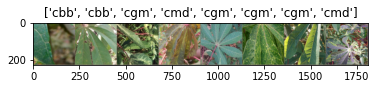

In [73]:
#View Images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(datasets_mean)
    std = np.array(datasets_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


## **Train Model**

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=70):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    inputs = torch.add(inputs, torch.rand_like(inputs))
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## **No freeze Layers**

In [0]:
model33a = models.resnet101(pretrained=True)
num_ftrs = model33a.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model33a.fc = nn.Linear(num_ftrs, 5)
model33a.load_state_dict(torch.load('/content/drive/My Drive/model33a.pth'))

model33a = model33a.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model33a.parameters(), lr=0.001, momentum=0.5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)


In [0]:
model33a = train_model(model33a, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=50)

Epoch 0/49
----------
train Loss: 0.1507 Acc: 0.9519
valid Loss: 0.3612 Acc: 0.9109

Epoch 1/49
----------
train Loss: 0.1495 Acc: 0.9530
valid Loss: 0.3786 Acc: 0.9156

Epoch 2/49
----------
train Loss: 0.1582 Acc: 0.9482
valid Loss: 0.3595 Acc: 0.9081

Epoch 3/49
----------
train Loss: 0.1585 Acc: 0.9471
valid Loss: 0.3691 Acc: 0.9053

Epoch 4/49
----------
train Loss: 0.1504 Acc: 0.9516
valid Loss: 0.3827 Acc: 0.9099

Epoch 5/49
----------
train Loss: 0.1600 Acc: 0.9465
valid Loss: 0.3439 Acc: 0.9109

Epoch 6/49
----------


In [0]:
PATH = '/content/drive/My Drive/model33a.pth'
torch.save(model33a.state_dict(), PATH )

## **Freeze Layers**

In [0]:
model33b = torchvision.models.resnet101(pretrained=True)
for param in model33b.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model33b.fc.in_features
model33b.fc = nn.Linear(num_ftrs, 5)

model33b = model33b.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model33b.fc.parameters(), lr=0.01, momentum=0.5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
model33b = train_model(model33b, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=25)

In [0]:
PATH = '/content/drive/My Drive/model33b.pth'
torch.save(model33b.state_dict(), PATH )

## **Validation**

In [0]:
model = models.resnet101(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
imagenet_mean = [0.4850, 0.4560, 0.4060]
imagenet_std = [0.2290, 0.2240, 0.2250]
datasets_mean = [0.4471, 0.5011, 0.3216]
datasets_std = [0.1900, 0.1912, 0.1633]



model.load_state_dict(torch.load('/content/drive/My Drive/model33a.pth'))

validtransform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),transforms.Normalize(datasets_mean, datasets_std)])
data_dir = '/content/cassava/valid'
valid_datasets = datasets.ImageFolder(data_dir , transform=validtransform)
valid_loader = torch.utils.data.DataLoader(valid_datasets, batch_size=1, shuffle=False)


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def valid(model,testloader):
  with torch.no_grad():
    #### set the model eval mode
    model.eval()
    valid_acc = 0 
    for images , labels in testloader:
      ### set to the gpu 
      images = images.to(device)
      labels = labels.to(device)
      model.to(device)
            
      ### predict the image
      preds = model(images)
            #### pick the maximum index of value 
      preds = preds.detach().argmax(dim=1,keepdim=True)
      labels = labels.detach()
            #correct += pred.cpu().eq(target.view_as(pred)).sum().item()

      valid_acc += preds.eq(labels.view_as(preds)).sum().item()            
print(f"Validation accuracy : {(valid_acc/len(testloader.dataset)) * 100 :.0f}%")
valid(model=model, testloader=valid_loader)

## **VISUALIZE MODEL PREDICTION**

In [0]:
validtransform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),transforms.Normalize(datasets_mean, datasets_std)])
data_dir = '/content/cassava/valid'
valid_datasets = datasets.ImageFolder(data_dir , transform=validtransform)
valid_loader = torch.utils.data.DataLoader(valid_datasets, batch_size=1, shuffle=False)


def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
        
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## **Predict for kaggle**

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet101(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load('/content/drive/My Drive/model33a.pth'))
model.to(device)
model.eval()

testtransform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),transforms.Normalize(datasets_mean, datasets_std)])
data_dir = '/content/cassava/test'


test_datasets = datasets.ImageFolder(data_dir , transform=testtransform)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=1, shuffle=False)

class_name = valid_datasets.classes
#targets = dataset.targets

#Prediction for submission 
predictions = []
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        predict = model(data)
        _, max_index = torch.max(predict,1)
        predictions.append(max_index.cpu())


predictions = torch.cat(predictions)
class_names = np.array(class_name)
prediction_class = class_names[predictions]
#in test_dataset.imgs, in the first tuple we extract the image name from, it start from the 7iem character
filenames = [filename[24:] for filename,_ in test_datasets.imgs]
#create a pandas file
import pandas as pd
submission = pd.DataFrame.from_dict({'Category':prediction_class,'Id':filenames}
)
#create a csv file to submit from the panda file
submission.to_csv('name_submission.csv', header = True, index = False)

In [0]:
#!pip install kaggle

In [0]:
#submit to kaggle
#!kaggle competitions submit -c ammi-2020-convnets -f name_submission.csv -m "Message"